# Compressed Sensing Testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as scimg
from skimage import io
import cvxpy as cvx

In [2]:
x = np.sort(np.random.uniform(0,10,15))
y = 3 + 0.2*x + 0.1*np.random.randn(len(x))

In [3]:
# Sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394*np.pi*t) + np.sin(3266*np.pi*t)
yt = spfft.dct(y, norm='ortho')

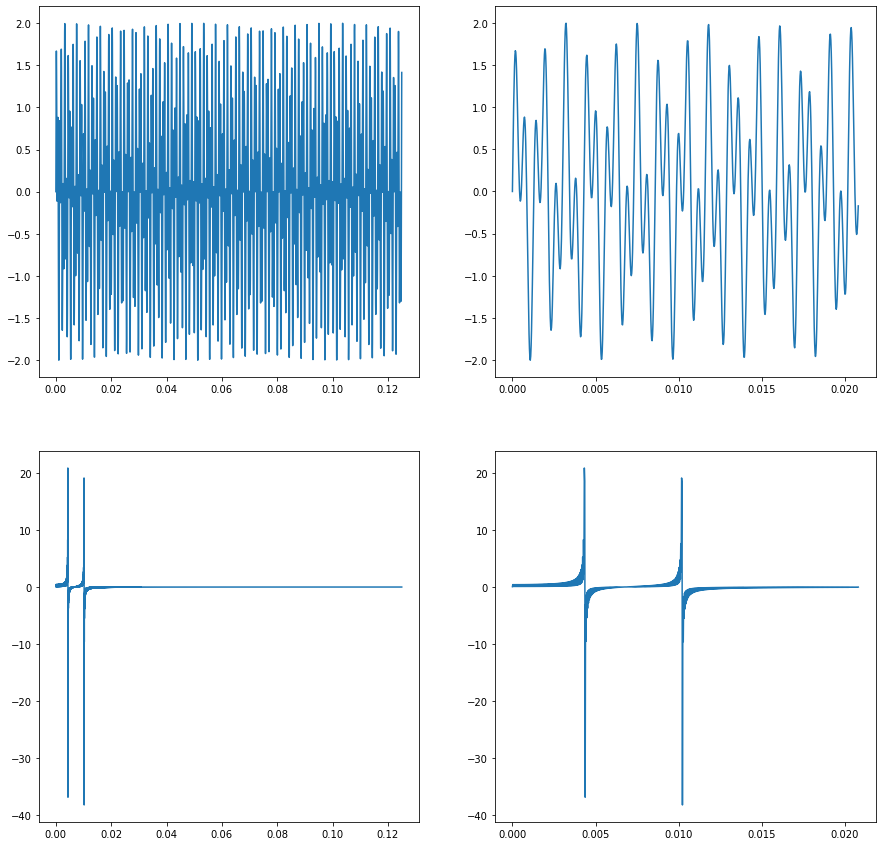

In [4]:
plt.figure(figsize=(15,15));
plt.subplot(221);plt.plot(t,y)
plt.subplot(222);plt.plot(t[0:5000//6],y[0:5000//6])
plt.subplot(223);plt.plot(t,yt)
plt.subplot(224);plt.plot(t[0:5000//6],yt[0:5000//6])

### extract small smaple of signal

In [5]:
m = 500 
# random sample of indice
ri = np.random.choice(n, m, replace=False) 
ri.sort()
t2 = t[ri]
y2 = y[ri]

(0, 0.02)

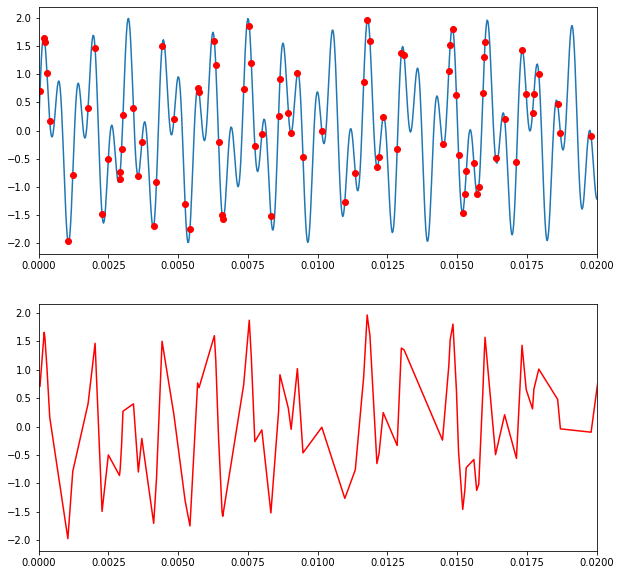

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(211); 
plt.plot(t[0:5000//6],y[0:5000//6],t2,y2,'ro')
plt.xlim(0,0.02)
plt.subplot(212); plt.plot(t2,y2,'r')
plt.xlim(0,0.02)

### create idct matrix operator

In [7]:
A = spfft.idct(np.identity(n),norm='ortho',axis=0)
A = A[ri]

### L1 optimization

In [8]:
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx,1))
constrains = [A*vx == y2]
prob = cvx.Problem(objective, constrains)
result = prob.solve(verbose=True)

/Users/chiuhsien/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -3.552e-23  -0.000e+00  +2e+04  9e-01  1e-02  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +1.350e+02  +1.351e+02  +9e+03  9e-01  5e-03  5e-01  9e-01  0.6514  9e-02   1  1  1 |  0  0
 2  +1.664e+02  +1.666e+02  +8e+03  7e-01  4e-03  5e-01  8e-01  0.3624  6e-01   1  1  0 |  0  0
 3  +2.095e+02  +2.096e+02  +5e+03  5e-01  2e-03  4e-01  5e-01  0.5420  3e-01   1  0  0 |  0  0
 4  +2.561e+02  +2.562e+02  +3e+03  2e-01  1e-03  2e-01  3e-01  0.6634  3e-01   1  0  0 |  0  0
 5  +2.917e+02  +2.917e+02  +1e+03  1e-01  7e-04  1e-01  1e-01  0.5062  2e-01   1  0  0 |  0  0
 6  +3.236e+02  +3.236e+02  +8e+02  7e-02  4e-04  7e-02  8e-02  0.6469  2e-01   1  0  0 |  0  0
 7  +3.413e+02  +3.413e+02  +4e+02  3e-02  2e-04  4e-02  4e-02  0.6611  3e-01   1  1  1 |  0  0
 8  +3.510e+02  +3.511e+02  +2e+02  2e-02  9e-

### reconstruct signal

In [9]:
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

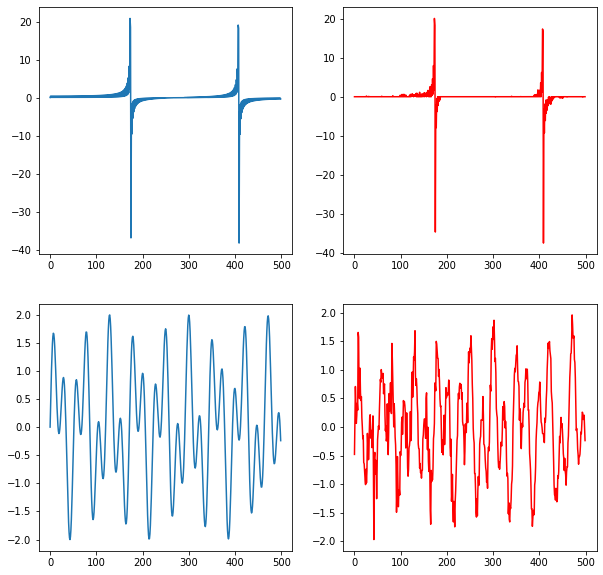

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(221);plt.plot(yt[0:500])
plt.subplot(222);plt.plot(x[0:500],'r')
plt.subplot(223);plt.plot(y[0:500])
plt.subplot(224);plt.plot(sig[0:500],'r')

## Reconstruct of Image Example

In [11]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image and downsize for speed
Xorig1 = io.imread('test.jpeg') # read in grayscale
Xorig = io.imread('test.jpeg', as_gray=True) # read in grayscale
X = scimg.zoom(Xorig, 0.04)
ny,nx = X.shape

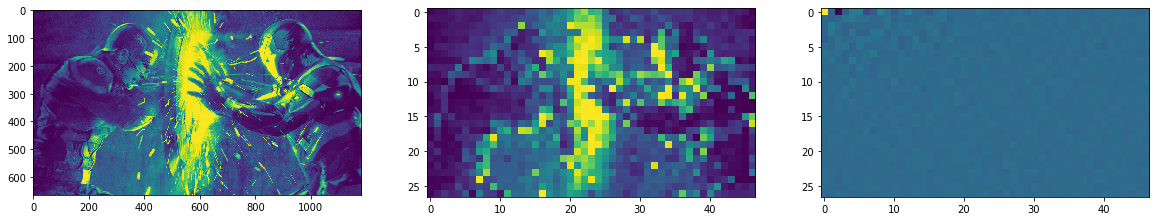

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(131);plt.imshow(Xorig)
plt.subplot(132);plt.imshow(X)
plt.subplot(133);plt.imshow(dct2(X))

In [13]:
k = round(nx * ny * 0.6)
ri = np.random.choice(nx * ny, k, replace=False)
b = X.T.flat[ri]

### create dct matrix operator using kron (memory errors for large ny*nx)

In [14]:
A = np.kron(spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0))
A = A[ri,:] # same as phi times kron

###   L1 optimization

In [15]:
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

/Users/chiuhsien/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.709e-22  -0.000e+00  +1e+04  1e+00  1e-02  1e+00  4e+00    ---    ---    1  1  - |  -  - 
 1  +2.225e+01  +2.247e+01  +3e+03  9e-01  4e-03  6e-01  1e+00  0.7287  1e-01   0  1  1 |  0  0
 2  +4.862e+01  +4.866e+01  +5e+02  4e-01  6e-04  9e-02  2e-01  0.8643  2e-02   1  0  1 |  0  0
 3  +1.119e+02  +1.119e+02  +2e+02  1e-01  2e-04  3e-02  6e-02  0.7359  5e-02   1  1  1 |  0  0
 4  +1.410e+02  +1.410e+02  +5e+01  4e-02  6e-05  1e-02  2e-02  0.6843  4e-02   1  1  1 |  0  0
 5  +1.505e+02  +1.505e+02  +2e+01  2e-02  2e-05  5e-03  8e-03  0.6925  1e-01   1  1  1 |  0  0
 6  +1.542e+02  +1.542e+02  +8e+00  6e-03  8e-06  2e-03  3e-03  0.7259  1e-01   1  1  1 |  0  0
 7  +1.554e+02  +1.554e+02  +3e+00  2e-03  3e-06  1e-03  1e-03  0.7504  2e-01   1  1  1 |  0  0
 8  +1.559e+02  +1.559e+02  +1e+00  1e-03  1e-

### reconstruct image

In [16]:
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = (idct2(Xat))

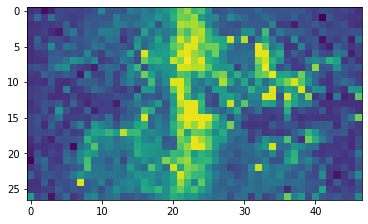

In [17]:
plt.imshow(Xa)